In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from numpy import median 
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from scipy import signal 
from scipy import interpolate
from scipy.ndimage.interpolation import shift
import cPickle as pkl
import seaborn as sns
import itertools as it
from __future__ import division
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from lab.classes.dbclasses import dbMouse
from lab.analysis import behavior_analysis as ba

In [2]:
%run Helper_Functions.ipynb

In [ ]:
mouseList = ['bv119', 'bv125', 'bv132', 'bv135', 'bv136', 'bv138', 'bv140', 'bv142', 'bv143']

allData = []
run_start_velocity_traces = []
run_stop_velocity_traces = []
for mouseID in mouseList:
    print(mouseID), 
    labels = pd.read_excel('/data2/bert/CA3/Histology/Subtypes.xlsx', sheet_name = mouseID)
    
    exptList = [expt for expt in dbMouse(mouseID).imagingExperiments() if \
                expt.experimentType != 'rippleActivity']
    
    dataBuffer = []
    for expt in exptList:
        if ('all' or 'all_fissa') in expt.labels(): 
            if expt.hasDfofTracesFile(): 
                subtype_id = ROI_planeID(expt, 'all_fissa') 
                roi_label = 'all_fissa'
                
                imData = np.squeeze(expt.imagingData(dFOverF = 'from_file', label = roi_label))
                velocity = expt.velocity(smoothing = 'hanning', window_length = 5)[0]
                
                for roiID in xrange(imData.shape[0]): 
                    cell_data = imData[roiID, :]
                    average_run_start_trace = get_average_run_start_trace(expt, cell_data, \
                                    velocity, velocity_cut_off = 0.2, \
                                    length_of_window_in_seconds = 3, number_of_data_points = 50)
                    average_run_stop_trace = get_average_run_stop_trace(expt, cell_data, \
                                    velocity, velocity_cut_off = 0.2, \
                                    length_of_window_in_seconds = 3, number_of_data_points = 50)
    
                    dataBuffer.append({'expt': expt.trial_id, 
                                    'Subtype': labels['Subtype'][subtype_id[roiID]], 
                                    'Layer': labels['Layer'][subtype_id[roiID]], 
                                    'Avg_Run_Start_Trace': average_run_start_trace,
                                    'Avg_Run_Stop_Trace': average_run_stop_trace,
                                    'Region': labels['Region'][subtype_id[roiID]],
                                    'Imaging_Plane': subtype_id[roiID], 
                                    'SATB1': labels['SATB1'][subtype_id[roiID]]})
    
    dataBuffer = pd.DataFrame(dataBuffer)
    for planenumber in filter(lambda v: v==v, np.unique(dataBuffer['Imaging_Plane'])):
        run_start_cell_traces_from_different_expts = []
        for array in dataBuffer[dataBuffer.Imaging_Plane == planenumber]['Avg_Run_Start_Trace'].values:
            run_start_cell_traces_from_different_expts.append(array)
        avg_run_start_trace = np.nanmean(stats.zscore(run_start_cell_traces_from_different_expts, axis = 1), axis = 0)
        
        run_stop_cell_traces_from_different_expts = []
        for array in dataBuffer[dataBuffer.Imaging_Plane == planenumber]['Avg_Run_Stop_Trace'].values:
            run_stop_cell_traces_from_different_expts.append(array)
        avg_run_stop_trace = np.nanmean(stats.zscore(run_stop_cell_traces_from_different_expts, axis = 1), axis = 0)
        
        
        allData.append({'mouseID': mouseID, 'Average_Run_Start_Trace': avg_run_start_trace,
                        'Average_Run_Stop_Trace': avg_run_stop_trace,
                       'Subtype': dataBuffer[dataBuffer.Imaging_Plane == planenumber]['Subtype'].iloc[0],
                       'Layer': dataBuffer[dataBuffer.Imaging_Plane == planenumber]['Layer'].iloc[0],
                       'Region': dataBuffer[dataBuffer.Imaging_Plane == planenumber]['Region'].iloc[0],
                       'Imaging_Plane': dataBuffer[dataBuffer.Imaging_Plane == planenumber]['Imaging_Plane'].iloc[0],
                       'SATB1': dataBuffer[dataBuffer.Imaging_Plane == planenumber]['SATB1'].iloc[0]})
    
allData = pd.DataFrame(allData)  

In [4]:
allData = allData[allData.Region != 'CA1']
run_start_velocity_traces = np.asarray(run_start_velocity_traces)
run_stop_velocity_traces = np.asarray(run_stop_velocity_traces)

/home/bert/.local/lib/python2.7/site-packages/pandas/core/missing.py:44: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [5]:
allData = allData[allData.Subtype == 'CB']

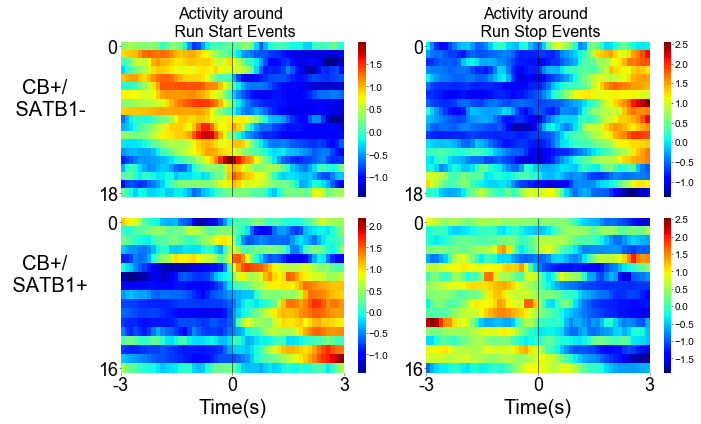

In [6]:
fig, ax = plt.subplots(2,2,figsize = (10,6))
CB_SATB1_negative_run_start_traces = []
for array in allData[allData.SATB1 == '-'].Average_Run_Start_Trace.values:
    CB_SATB1_negative_run_start_traces.append(array)    
CB_SATB1_negative_run_start_traces = np.asarray(CB_SATB1_negative_run_start_traces)

cell_sorting = np.argsort(np.argmax(CB_SATB1_negative_run_start_traces, axis = 1))
CB_SATB1_neg_run_start_traces = CB_SATB1_negative_run_start_traces[cell_sorting,:]
sns.heatmap(CB_SATB1_neg_run_start_traces, cmap = 'jet', \
            yticklabels = len(CB_SATB1_neg_run_start_traces) - 1, xticklabels = False, \
            rasterized = True, ax = ax[0,0])
ax[0,0].axvline(x = 25, color = 'black', linewidth = 0.5)
ax[0,0].set_title('Activity around \n Run Start Events', fontsize = 16)
ax[0,0].set_ylabel('CB+/ \n SATB1-', rotation = 0, labelpad = 50, fontsize = 20)
ax[0,0].set_yticklabels(ax[0,0].get_yticklabels(), rotation = 0, fontsize = 18)

CB_SATB1_negative_run_stop_traces = []
for array in allData[allData.SATB1 == '-'].Average_Run_Stop_Trace.values:
    CB_SATB1_negative_run_stop_traces.append(array)
CB_SATB1_negative_run_stop_traces = np.asarray(CB_SATB1_negative_run_stop_traces)

CB_SATB1_neg_run_stop_traces = CB_SATB1_negative_run_stop_traces[cell_sorting,:]
sns.heatmap(CB_SATB1_neg_run_stop_traces, cmap = 'jet', \
            yticklabels = len(CB_SATB1_neg_run_stop_traces) - 1, xticklabels = False, \
            rasterized = True, ax = ax[0,1])
ax[0,1].axvline(x = 25, color = 'black', linewidth = 0.5)
ax[0,1].set_title('Activity around \n Run Stop Events', fontsize = 16)
ax[0,1].set_yticklabels(ax[0,1].get_yticklabels(), rotation = 0, fontsize = 18)

CB_SATB1_positive_run_start_traces = []
for array in allData[allData.SATB1 == '+'].Average_Run_Start_Trace.values:
    CB_SATB1_positive_run_start_traces.append(array)
CB_SATB1_positive_run_start_traces = np.asarray(CB_SATB1_positive_run_start_traces)

cell_sorting2 = np.argsort(np.argmax(CB_SATB1_positive_run_start_traces, axis = 1))
CB_SATB1_pos_run_start_traces = CB_SATB1_positive_run_start_traces[cell_sorting2,:]
sns.heatmap(CB_SATB1_pos_run_start_traces, cmap = 'jet', \
            yticklabels = len(CB_SATB1_pos_run_start_traces) - 1, xticklabels = False, \
            rasterized = True, ax = ax[1,0])
ax[1,0].axvline(x = 25, color = 'black', linewidth = 0.5)
ax[1,0].set_yticklabels(ax[1,0].get_yticklabels(), rotation = 0, fontsize = 18)
ax[1,0].set_ylabel('CB+/ \n SATB1+', rotation = 0, labelpad = 50, fontsize = 20)
ax[1,0].set_xticks([0, 25, 50])
ax[1,0].set_xticklabels(['-3', '0', '3'], fontsize = 18)
ax[1,0].set_xlabel('Time(s)', fontsize = 20)

CB_SATB1_positive_run_stop_traces = []
for array in allData[allData.SATB1 == '+'].Average_Run_Stop_Trace.values:
    CB_SATB1_positive_run_stop_traces.append(array)
CB_SATB1_positive_run_stop_traces = np.asarray(CB_SATB1_positive_run_stop_traces)

CB_SATB1_pos_run_stop_traces = CB_SATB1_positive_run_stop_traces[cell_sorting2,:]
sns.heatmap(CB_SATB1_pos_run_stop_traces, cmap = 'jet', \
            yticklabels = len(CB_SATB1_pos_run_stop_traces) - 1, xticklabels = False, \
            rasterized = True, ax = ax[1,1])
ax[1,1].axvline(x = 25, color = 'black', linewidth = 0.5)
ax[1,1].set_yticklabels(ax[1,1].get_yticklabels(), rotation = 0, fontsize = 18)
ax[1,1].set_xticks([0, 25, 50])
ax[1,1].set_xticklabels(['-3', '0', '3'], fontsize = 18)
ax[1,1].set_xlabel('Time(s)', fontsize = 20)

fig.tight_layout()
plt.savefig('CB_SATB1_Heatmaps.svg', format = 'svg', dpi = 1200, transparent = True)